In [1]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt

## Fonctions

In [2]:
def e_greedy(state, epsilon, q, env):
    exp_exp_tradeoff = random.uniform(0, 1)
    if exp_exp_tradeoff > epsilon:
        return np.argmax(q[state, :])
    return env.action_space.sample()


def maj_q(q_local, state, action, new_state, reward, learning_rate, gamma):
    q_init = q_local[state, action]
    max_state = np.max(q_local[new_state, :])
    q_local[state, action] = (1 - learning_rate) * q_init + learning_rate * (reward + gamma * max_state)
    return q_local

def is_fractile(episode_actuel, episode_total):
    return episode_actuel % (episode_total/50) == 0

def show_q(local_q):
    env = gym.make("Taxi-v3", render_mode="human")
    state = env.reset()[0]
    for step in range(200):
        env.render()
        action = np.argmax(local_q[state, :])
        (new_state, reward, done, info, _) = env.step(action)
        if done:
            break
        state = new_state
    env.close()

# Renforcement

In [3]:
def train(epsilon = 1.0, max_steps = 200, alpha = 0.7, gamma = 0.8, max_epsilon = 1.0, min_epsilon = 0.05, decay_rate = 0.01, total_episodes = 750, total_test_episodes = 1):
    title = "Epsilon: {}, learning_rate: {}, gamma: {} ".format(epsilon, alpha, gamma)
    env = gym.make("Taxi-v3", render_mode="ansi")
    env.reset()
    action_size = env.action_space.n
    state_size = env.observation_space.n
    q = np.zeros((state_size, action_size))
    rewards = []
    for i in range(0, 50):
        print('=', end= '')
    print()
    for episode in range(total_episodes):
        if is_fractile(episode, total_episodes):
            print("\b=>", end='')
        (state) = env.reset()[0]
        count = 0
        for step in range(max_steps):
            action = e_greedy(state, epsilon, q, env)
            (new_state, reward, done, info, _) = env.step(action)
            q = maj_q(q, state, action, new_state, reward, alpha, gamma)
            state = new_state
            count += reward
            if done:
                rewards.append(count)
                break
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
    plt.title(title)
    plt.plot(rewards, color="red")
    plt.show()
    env = gym.make("Taxi-v3", render_mode="ansi")
    env.reset()

    for episode in range(total_test_episodes):
        state = env.reset()[0]
        total_rewards = 0
        for step in range(max_steps):
            env.render()
            action = np.argmax(q[state, :])
            (new_state, reward, done, info, _) = env.step(action)
            total_rewards += reward
            if done:
                break
            state = new_state
    env.close()
    return q

==================================================>

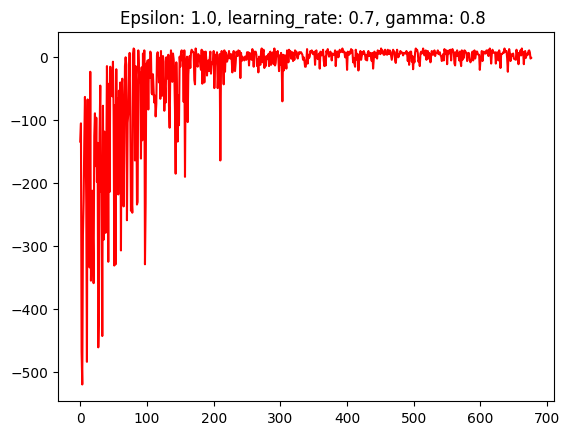

In [4]:
q = train()

In [8]:
show_q(q)

On remarque que si epsilon descend trop bas, en cas de problème dans Q, l'agent peux executer en boucle une action qui ne le change pas de position (ex : récupérer l'utilisateur). Si celui-ci est à 0.01, en cas de problème, il faudrait environ 100 actions pour espérer que le e-greedy en prenne une aléatoire qui q un impact sur sa position.

# Deep-Q Learning

In [15]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import gym
from kaggle_environments import make, evaluate
from gym import spaces

device = 'cpu'

class ConnectFourGym(gym.Env):
    def __init__(self, agent2="random"):
        ks_env = make("connectx", debug=True)
        self.env = ks_env.train([None, agent2])
        self.rows = ks_env.configuration.rows
        self.columns = ks_env.configuration.columns
        # Learn about spaces here: http://gym.openai.com/docs/#spaces
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=2,
                                            shape=(1,self.rows,self.columns), dtype=int)
        # Tuple corresponding to the min and max possible rewards
        self.reward_range = (-10, 1)
        # StableBaselines throws error if these are not defined
        self.spec = None
        self.metadata = None
    def reset(self):
        self.obs = self.env.reset()
        return np.array(self.obs['board']).reshape(1,self.rows,self.columns)
    def change_reward(self, old_reward, done):
        if old_reward == 1: # The agent won the game
            return 1
        elif done: # The opponent won the game
            return -1
        else: # Reward 1/42
            return 1/(self.rows*self.columns)
    def step(self, action):
        # Check if agent's move is valid
        is_valid = (self.obs['board'][int(action)] == 0)
        if is_valid: # Play the move
            self.obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
        else: # End the game and penalize agent
            reward, done, _ = -10, True, {}
        return np.array(self.obs['board']).reshape(1,self.rows,self.columns), reward, done, _

env = ConnectFourGym(agent2="random")

import torch as th
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class CustomCNN(BaseFeaturesExtractor):

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int=128):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # CxHxW images (channels first)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )
        self.cnn.to(device)

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())
        self.linear.to(device)

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
)

policy_kwargs.get('features_extractor_class')

# Initialize agent
model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, verbose=0, device=device)
model.learn(total_timesteps=60000)

def agent1(obs, config):
    # Use the best model to select a column
    col, _ = model.predict(np.array(obs['board']).reshape(1, 6, 7))
    # Check if selected column is valid
    is_valid = (obs['board'][int(col)] == 0)
    # If not valid, select random move.
    if is_valid:
        return int(col)
    else:
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

env = make("connectx")

# Two random agents play one game round
env.run([agent1, "random"])

def get_win_percentages(agent1, agent2, n_rounds=100):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))

get_win_percentages(agent1=agent1, agent2="random")



cpu
Agent 1 Win Percentage: 0.76
Agent 2 Win Percentage: 0.24
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


# Alphago Zero

In [16]:
!git clone https://github.com/plkmo/AlphaZero_Connect4.git

Cloning into 'AlphaZero_Connect4'...


In [ ]:
%cd AlphaZero_Connect4\src

In [22]:
!python main_pipeline.py

C:\Users\Bastien Audu\PycharmProjects\TP_Reinforcment_Bonnevay\AlphaZero_Connect4\src
^C
